In [1]:
# PyTorch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

# ETC
import wandb
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path as osp
import random
import torchmetrics
from PIL import Image

In [2]:
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64

In [3]:
pl.seed_everything(125)

Global seed set to 125


125

## Load Data (Manually)

In [4]:
train_root = './seg_train/'
val_root = './seg_test/'
pred_root = './seg_pred/'

In [5]:
train_root

'./seg_train/'

In [6]:
os.listdir(train_root)

['buildings', 'sea', 'glacier', 'street', 'mountain', 'forest']

In [7]:
os.listdir(osp.join(train_root, 'buildings'))[0]

'3638.jpg'

In [8]:
train_list = []
train_category = []
for category in os.listdir(train_root):
    for file in os.listdir(osp.join(train_root, category)):
        train_list.append(osp.join(train_root, category, file))
        train_category.append(category)
        
train_list = np.array(train_list)
train_category = np.array(train_category)

In [9]:
val_list = []
val_category = []
for category in os.listdir(val_root):
    for file in os.listdir(osp.join(val_root, category)):
        val_list.append(osp.join(val_root, category, file))
        val_category.append(category)
        
val_list = np.array(val_list)
val_category = np.array(val_category)

In [10]:
train_idx = [i for i in range(len(train_list))]
val_idx = [i for i in range(len(val_list))]
random.shuffle(train_idx)
random.shuffle(val_idx)

In [11]:
train_list = train_list[train_idx]
train_category = train_category[train_idx]

val_list = val_list[val_idx]
val_category = val_category[val_idx]

In [12]:
print(len(train_list))
print(len(val_list))

14034
3000


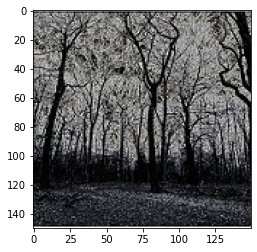

'forest'

In [13]:
img = Image.open(train_list[0])
plt.imshow(img)
plt.show()
train_category[0]

In [14]:
to_tensor = transforms.ToTensor()

In [15]:
to_tensor(img).shape

torch.Size([3, 150, 150])

### One Hot Encoding

In [16]:
category = np.unique(train_category)
category

array(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'],
      dtype='<U9')

In [17]:
def cat_to_num(cat):
    return np.where(category == cat)[0].item()

In [18]:
cat_map = np.vectorize(cat_to_num)

In [19]:
train_target = torch.tensor(cat_map(train_category))
train_target

tensor([1, 4, 5,  ..., 1, 4, 4])

In [20]:
train_label = F.one_hot(train_target)
train_label

tensor([[0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        ...,
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0]])

In [21]:
def to_onehot(cat_list):
    return F.one_hot(torch.tensor(cat_map(cat_list)))

In [22]:
class IntelImage(Dataset):
    def __init__(self, X_url, y_list):
        self.X_list = to_tensor(X_list)
        self.y_list = to_onehot(y_list)
    
    def __len__(self):
        return len(self.X_list)
    
    def __getitem__(self, idx):
        return self.X_list[idx], self.y_list[idx]

## Load Data (With ImageFolder)

In [23]:
df_train = datasets.ImageFolder(root=train_root, transform=transforms.ToTensor())

In [24]:
df_train

Dataset ImageFolder
    Number of datapoints: 14034
    Root location: ./seg_train/
    StandardTransform
Transform: ToTensor()

In [25]:
dl_train = DataLoader(df_train, shuffle=True)

In [26]:
it = iter(dl_train)

In [27]:
X, y = next(it)

In [28]:
X.shape

torch.Size([1, 3, 150, 150])

In [29]:
y

tensor([1])

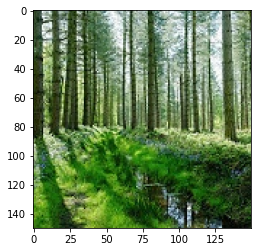

tensor([1])


In [30]:
plt.imshow(X[0].permute([1,2,0]))
plt.show()
print(y)

### Calc mean & std

In [31]:
# mean = torch.zeros((3,))
# std = torch.zeros((3,))
# for X, _ in dl_train:
#     for i in range(3):
#         mean[i] += X[:,i,:,:].mean()
#         std[i] += X[:,i,:,:].std()
# mean.div_(len(dl_train))
# std.div_(len(dl_train))

In [32]:
mean = torch.tensor([0.4302, 0.4575, 0.4538])

In [33]:
std = torch.tensor([0.2355, 0.2345, 0.2429])

## Load Data (With normalization)

In [34]:
class ImageTransform():
    def __init__(self, mean, std):
        self.trsf = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        
    def __call__(self, img):
        return self.trsf(img)

In [35]:
df_train = datasets.ImageFolder(root=train_root, transform=ImageTransform(mean, std))
df_val = datasets.ImageFolder(root=val_root, transform=ImageTransform(mean, std))

In [36]:
df_train

Dataset ImageFolder
    Number of datapoints: 14034
    Root location: ./seg_train/
    StandardTransform
Transform: <__main__.ImageTransform object at 0x7f8a0e18ed40>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


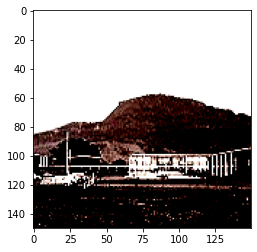

In [37]:
plt.imshow(df_train[0][0].permute([1,2,0]))
plt.show()

In [38]:
for i, (X, y) in enumerate(df_train):
    if X.shape != torch.Size([3, 150, 150]):
        print(i)
        print(X.shape)

1637
torch.Size([3, 124, 150])
2196
torch.Size([3, 113, 150])
2483
torch.Size([3, 108, 150])
2756
torch.Size([3, 133, 150])
2789
torch.Size([3, 115, 150])
2944
torch.Size([3, 135, 150])
3882
torch.Size([3, 136, 150])
3899
torch.Size([3, 108, 150])
4091
torch.Size([3, 113, 150])
4475
torch.Size([3, 110, 150])
4624
torch.Size([3, 105, 150])
4831
torch.Size([3, 111, 150])
4876
torch.Size([3, 120, 150])
5161
torch.Size([3, 149, 150])
5350
torch.Size([3, 143, 150])
5381
torch.Size([3, 146, 150])
5464
torch.Size([3, 134, 150])
5483
torch.Size([3, 142, 150])
5493
torch.Size([3, 123, 150])
5499
torch.Size([3, 119, 150])
5556
torch.Size([3, 102, 150])
5912
torch.Size([3, 76, 150])
5946
torch.Size([3, 97, 150])
6224
torch.Size([3, 111, 150])
6535
torch.Size([3, 111, 150])
6549
torch.Size([3, 135, 150])
7120
torch.Size([3, 134, 150])
7319
torch.Size([3, 135, 150])
7375
torch.Size([3, 123, 150])
7472
torch.Size([3, 113, 150])
7483
torch.Size([3, 142, 150])
7684
torch.Size([3, 144, 150])
7831
torch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


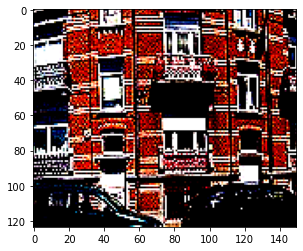

In [39]:
plt.imshow(df_train[1637][0].permute([1,2,0]))
plt.show()

In [40]:
class NewImageTransform():
    def __init__(self, mean, std):
        self.trsf = transforms.Compose([
            transforms.Resize((150, 150)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        
    def __call__(self, img):
        return self.trsf(img)

### Test

In [41]:
X_temp = df_train[0][0]
print(X_temp.shape)
X_temp = nn.Conv2d(3, 16, 3, padding=1)(X_temp)
print(X_temp.shape)
X_temp = nn.MaxPool2d(kernel_size=2, stride=2)(X_temp)
print(X_temp.shape)
X_temp = nn.Conv2d(16, 32, 3, padding=1)(X_temp)
print(X_temp.shape)
X_temp = nn.MaxPool2d(kernel_size=2, stride=2)(X_temp)
print(X_temp.shape)
X_temp = nn.Conv2d(32, 64, 3, padding=1)(X_temp)
print(X_temp.shape)
X_temp = nn.MaxPool2d(kernel_size=2, stride=2)(X_temp)
print(X_temp.shape)
X_temp = nn.Conv2d(64, 128, 3, padding=1)(X_temp)
print(X_temp.shape)
X_temp = nn.MaxPool2d(kernel_size=2, stride=2)(X_temp)
print(X_temp.shape)
X_temp = nn.Conv2d(128, 256, 3, padding=1)(X_temp)
print(X_temp.shape)
X_temp = nn.MaxPool2d(kernel_size=2, stride=2)(X_temp)
print(X_temp.shape)

torch.Size([3, 150, 150])
torch.Size([16, 150, 150])
torch.Size([16, 75, 75])
torch.Size([32, 75, 75])
torch.Size([32, 37, 37])
torch.Size([64, 37, 37])
torch.Size([64, 18, 18])
torch.Size([128, 18, 18])
torch.Size([128, 9, 9])
torch.Size([256, 9, 9])
torch.Size([256, 4, 4])


## Main - PyTorch Lightning (Basic)

In [42]:
class IIC_Basic(pl.LightningModule):
    def __init__(self, hparams=None):
        super().__init__()
        
        layers = []
        in_channels = 3
        classes = 6
        image_size = 150
        
        cfg = [16, 32, 64, 128, 256]
        
        for v in cfg:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            relu = nn.ReLU(inplace=True)
            maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
            layers += [conv2d, relu, maxpool]
            in_channels = v
            image_size = image_size // 2
        
        layers += [nn.Flatten()]
        
        in_features = cfg[-1] * image_size ** 2
        fc_cfg = [256]
        
        for v in fc_cfg:
            fc = nn.Linear(in_features, v)
            bn = nn.BatchNorm1d(v)
            relu = nn.ReLU(inplace=True)
            drop = nn.Dropout(0.1)
            layers += [fc, bn, relu, drop]
            in_features = v
        
        layers += [nn.Linear(in_features, 6)]
        
        self.net = nn.Sequential(*layers)
        
        self.learning_rate = hparams['learning_rate']
        self.batch_size = hparams['batch_size']
        self.epochs = hparams['epochs']
        
        self.accuracy = torchmetrics.classification.Accuracy()
        
        self.save_hyperparameters(hparams)
        
    def forward(self, x):
        return self.net(x)
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        
        y_hat = self(X)
        
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)
        
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        
        y_hat = self(X)
        
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)
        
        self.log('val_loss', loss)
        self.log('val_acc', acc)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": ReduceLROnPlateau(
                    optimizer, 
                    mode="min", 
                    patience=3, 
                    min_lr=1e-6
                ),
                "interval": "epoch",
                "monitor": "val_loss",
                "strict": True,
            }
        }
    
    def prepare_data(self):
        self.ds_train = datasets.ImageFolder(
            root=train_root,
            transform=NewImageTransform(mean, std)
        )
        self.ds_val = datasets.ImageFolder(
            root=val_root,
            transform=NewImageTransform(mean, std)
        )
    
    def train_dataloader(self):
        return DataLoader(self.ds_train, batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=self.batch_size)

In [43]:
hparams = {
    "learning_rate": 1e-3,
    "batch_size": BATCH_SIZE,
    "epochs": 30
}

In [44]:
model = IIC_Basic(hparams=hparams)

In [45]:
model

IIC_Basic(
  (net): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_di

In [46]:
wandb_logger = WandbLogger(
    project='IIC'
)

wandb: Currently logged in as: axect (use `wandb login --relogin` to force relogin)


In [47]:
trainer = Trainer(
    logger=wandb_logger,
    max_epochs=hparams["epochs"],
    gpus=AVAIL_GPUS,
    enable_progress_bar=False,
    callbacks=[
        LearningRateMonitor(logging_interval="epoch")
    ]
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | net      | Sequential | 1.4 M 
1 | accuracy | Accuracy   | 0     
----------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.774     Total estimated model params size (MB)
/home/xteca/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/xteca/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the v

In [ ]:
wandb.finish()